In [81]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import sys
import contextily as ctx
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

import logging
logging.getLogger().setLevel(logging.INFO)
from dotenv import load_dotenv
load_dotenv()

sys.path.append(os.path.realpath('../'))
from util.isochrones import Isochrones
from util.extract_urbancenter import ExtractCenters

DROOT = '../1-data/'

cities = pd.read_excel(os.path.join(DROOT, '1-research', 'cities.xlsx'))
# cities = cities[cities.Country=='NLD']
cities.head(3)

,City,Country,ID_HDC_G0
0,Vienna,AUT,3027
1,Graz,AUT,3000
2,Brussels,BEL,2135


In [82]:
isochrones = []
iterator = tqdm(cities.iterrows())
for pid, city in iterator:
    
    # Extract urban center and read in as pickle
    iterator.set_description(f"=== Starting {city.City} ({city.ID_HDC_G0}) ===")
    pickle_path = os.path.join(DROOT, '3-traveltime-cities', f'{city.ID_HDC_G0}.isochrones.pcl')
    if os.path.exists(pickle_path):
        pickle = gpd.GeoDataFrame(pd.read_pickle(pickle_path))
        pickle['country'] = city.Country
        pickle['city_name'] = city.City
        geometry_ua = pickle.groupby('pid').progress_apply(lambda x: x.set_geometry('reach_geo').unary_union).rename('geometry_ua')
        pickle = pickle.merge(geometry_ua, on='pid').set_geometry('geometry_ua').set_crs('EPSG:4326')
        pickle['reach_ua_km2'] = pickle.set_geometry('geometry_ua').to_crs(pickle.estimate_utm_crs()).area
        isochrones.append(pickle)
    else:
        logging.info(f"City {city.City} didn't exist, skipping")

isochrones = pd.concat(isochrones)
isochrones.sample(2)

100%|██████████| 658/658 [00:02<00:00, 263.81it/s]0it [01:23,  1.22s/it]
=== Starting Utrecht (2180) ===: : 31it [01:26,  1.79s/it]              INFO:root:City Utrecht didn't exist, skipping
100%|██████████| 104/104 [00:00<00:00, 243.21it/s] 1.79s/it]
=== Starting Leiden (2138) ===: : 33it [01:27,  1.12s/it]   INFO:root:City Leiden didn't exist, skipping
=== Starting Arnhem (2226) ===: : 33it [01:27,  1.12s/it]INFO:root:City Arnhem didn't exist, skipping
=== Starting Perth (11640) ===: : 33it [01:27,  1.12s/it]INFO:root:City Perth didn't exist, skipping
=== Starting Sydney (13043) ===: : 33it [01:27,  1.12s/it]INFO:root:City Sydney didn't exist, skipping
=== Starting Melbourne (13023) ===: : 33it [01:27,  1.12s/it]INFO:root:City Melbourne didn't exist, skipping
=== Starting Adelaide (12977) ===: : 33it [01:27,  1.12s/it] INFO:root:City Adelaide didn't exist, skipping
=== Starting Auckland (13129) ===: : 33it [01:27,  1.12s/it]INFO:root:City Auckland didn't exist, skipping
=== Starting 

,uid,pid,startpt,tt_mnts,mode,modetime,dep_dt,source,city_id,isochrone,cell_pop,raster,reach_n,reach_km2,reach_pop,reach_geo,country,city_name,geometry_ua,reach_ua_km2
2691,3027-336-walking-15m-g,336,POINT (16.48076 48.14167),15,walking,walking,2023-06-13 08:30:00+02:00,g,3027,"POLYGON ((16.48867 48.14439, 16.48359 48.14912...",1357.612671,"POLYGON ((1283000.000 5678000.000, 1283000.000...",8.0,8000000.0,12667.849857,POLYGON ((16.46054401161778 48.136963093180725...,AUT,Vienna,"POLYGON ((16.23986 47.99577, 16.22705 47.99577...",1.206247e+09
1292,3216-215-walking-15m-g,215,POINT (21.02776 52.22551),15,walking,walking,2023-06-13 08:30:00+02:00,g,3216,"POLYGON ((21.02679 52.23077, 21.02525 52.23089...",7597.976074,"POLYGON ((1551000.000 6105000.000, 1551000.000...",8.0,8000000.0,61601.561523,POLYGON ((21.005975922554544 52.22064511502405...,POL,Warsaw,"POLYGON ((20.83099 52.13320, 20.81745 52.13320...",9.077865e+08


## Percentage of unary union of all modes reachable by that mode
Combines the total surface of that PID into one polygon, and calculates part reachable by mode

In [14]:
reach_km2 = isochrones[(isochrones.tt_mnts == 15)]
reach_km2['reach_ua_perc'] = reach_km2.reach_km2 / reach_km2.reach_ua_km2 
reach_km2[reach_km2.city_name == 'Amsterdam'].head(2)

/Users/ivo/opt/anaconda3/envs/DUTTv2/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,uid,pid,startpt,tt_mnts,mode,modetime,dep_dt,source,city_id,isochrone,...,raster,reach_n,reach_km2,reach_pop,reach_geo,country,city_name,geometry_ua,reach_ua_km2,reach_ua_perc
0,2167-0-driving-15m-b,0,POINT (4.78390 52.51746),15,driving,driving,2023-06-13 08:30:00+02:00,b,2167,"POLYGON ((4.62613 52.48624, 4.63128 52.48784, ...",...,"POLYGON ((351000.000 6135000.000, 351000.000 6...",447.0,447000000.0,627009.495065,POLYGON ((4.6348287322705035 52.42493220326197...,NLD,Amsterdam,"POLYGON ((4.62966 52.34707, 4.63031 52.35680, ...",1.210569e+09,0.369248
1,2167-0-cycling-15m-g,0,POINT (4.78390 52.51746),15,cycling,cycling,2023-06-13 08:30:00+02:00,g,2167,"POLYGON ((4.77698 52.51527, 4.77646 52.51031, ...",...,"POLYGON ((351000.000 6135000.000, 351000.000 6...",38.0,38000000.0,50474.159175,"POLYGON ((4.761149862643516 52.48336379128108,...",NLD,Amsterdam,"POLYGON ((4.62966 52.34707, 4.63031 52.35680, ...",1.210569e+09,0.031390


In [16]:
reach_km2_pivot = reach_km2.pivot_table(index=['city_id', 'pid'], columns=['mode'], values='reach_ua_perc')
reach_km2_pivot = reach_km2_pivot.merge(isochrones[['city_id', 'pid', 'raster', 'city_name', 'country']].drop_duplicates(), on=['city_id', 'pid'])
reach_km2_pivot = reach_km2_pivot.set_geometry('raster')
reach_km2_pivot.sort_values('cycling', ascending=False)

errors = reach_km2_pivot.driving < 0.8
# reach_km2_pivot = reach_km2_pivot[~errors]
print('errors: ', errors.sum())

reach_km2_pivot

errors:  12103


,city_id,pid,cycling,driving,walking,raster,city_name,country
0,1551,0,0.023816,0.385017,0.004962,"POLYGON ((-777000.000 4667000.000, -777000.000...",Lisbon,PRT
1,1551,1,0.073185,0.260213,0.016263,"POLYGON ((-776000.000 4667000.000, -776000.000...",Lisbon,PRT
2,1551,10,0.035007,0.252828,0.006483,"POLYGON ((-777000.000 4664000.000, -777000.000...",Lisbon,PRT
3,1551,100,0.044659,0.406089,0.009347,"POLYGON ((-803000.000 4653000.000, -803000.000...",Lisbon,PRT
4,1551,101,0.046359,0.409505,0.008830,"POLYGON ((-802000.000 4653000.000, -802000.000...",Lisbon,PRT
...,...,...,...,...,...,...,...,...
12110,3269,95,0.099096,0.227711,0.016867,"POLYGON ((1648000.000 6581000.000, 1648000.000...",Riga,LVA
12111,3269,96,0.070123,0.308542,0.014025,"POLYGON ((1649000.000 6581000.000, 1649000.000...",Riga,LVA
12112,3269,97,0.068781,0.295185,0.011463,"POLYGON ((1650000.000 6581000.000, 1650000.000...",Riga,LVA
12113,3269,98,0.045186,0.221091,0.006455,"POLYGON ((1651000.000 6581000.000, 1651000.000...",Riga,LVA


3it [00:04,  1.45s/it]


Text(0.5, 0.98, 'Reachability % from cell centroid using mode')

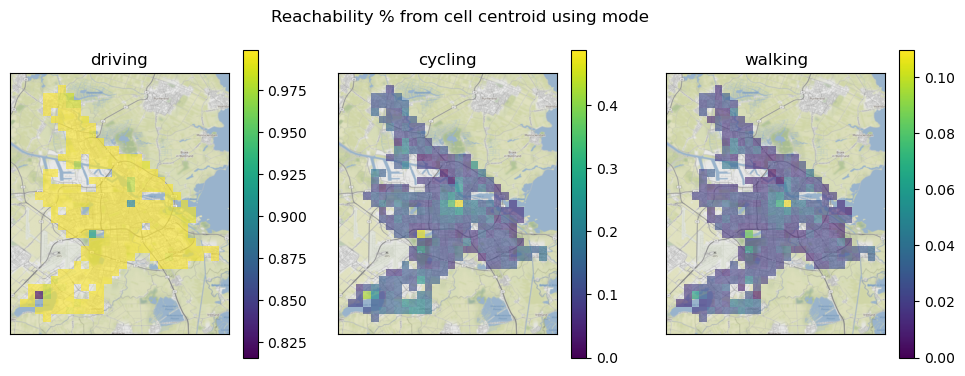

In [57]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True)
for x, mode in tqdm(enumerate(['driving', 'cycling', 'walking'])):
    ax = axs[x]
    reach_km2_pivot.plot(column=mode, legend=True, alpha=0.6, ax=ax)
    # reach_pop.apply(lambda x: ax.annotate(text=x['pid'], xy=x.raster.centroid.coords[0], ha='center', fontsize=6), axis=1)
    ax.set_title(mode)
    ax.set_xticks([])
    ax.set_yticks([])
    ctx.add_basemap(ax=ax, crs=reach_km2_pivot.crs, attribution='')
fig.suptitle("Reachability % of total options from cell centroid using mode (within 15 minutes)")

In [84]:
reach_pop = isochrones[(isochrones.tt_mnts == 15)]
reach_pop = reach_pop.pivot_table(index=['city_id', 'pid'], columns=['mode'], values='reach_pop')
reach_pop = reach_pop.drop_duplicates()
reach_pop = gpd.GeoDataFrame(reach_pop.merge(isochrones[['city_id', 'city_name', 'country', 'pid', 'raster']].drop_duplicates(), on=['city_id', 'pid']), geometry='raster')
reach_pop = reach_pop.sort_index()
reach_pop

,city_id,pid,cycling,driving,walking,city_name,country,raster
0,1551,0,30683.007447,6.231554e+05,13150.450163,Lisbon,PRT,"POLYGON ((-777000.000 4667000.000, -777000.000..."
1,1551,1,46171.631454,7.857957e+04,26761.682831,Lisbon,PRT,"POLYGON ((-776000.000 4667000.000, -776000.000..."
2,1551,10,75696.252991,3.001680e+05,16988.893738,Lisbon,PRT,"POLYGON ((-777000.000 4664000.000, -777000.000..."
3,1551,100,150749.028557,1.104671e+06,29230.497063,Lisbon,PRT,"POLYGON ((-803000.000 4653000.000, -803000.000..."
4,1551,101,178957.520020,1.041744e+06,31344.562271,Lisbon,PRT,"POLYGON ((-802000.000 4653000.000, -802000.000..."
...,...,...,...,...,...,...,...,...
12922,3269,95,152030.209686,2.379384e+05,32207.781006,Riga,LVA,"POLYGON ((1648000.000 6581000.000, 1648000.000..."
12923,3269,96,150850.717590,3.865558e+05,36691.207520,Riga,LVA,"POLYGON ((1649000.000 6581000.000, 1649000.000..."
12924,3269,97,170384.272766,4.682447e+05,27854.166138,Riga,LVA,"POLYGON ((1650000.000 6581000.000, 1650000.000..."
12925,3269,98,124442.178040,3.863018e+05,9493.608582,Riga,LVA,"POLYGON ((1651000.000 6581000.000, 1651000.000..."


,city_id,pid,cycling,driving,walking,city_name,country,raster
0,2123,0,87420.020813,3.314468e+05,20950.945831,Rotterdam [The Hague],NLD,"POLYGON ((316000.000 6094000.000, 316000.000 6..."
1,2123,1,87420.020813,1.522801e+03,18590.470734,Rotterdam [The Hague],NLD,"POLYGON ((317000.000 6094000.000, 317000.000 6..."
2,2123,10,251109.912354,6.241194e+05,57026.800537,Rotterdam [The Hague],NLD,"POLYGON ((316000.000 6092000.000, 316000.000 6..."
3,2123,100,301639.730225,8.349277e+05,59554.440918,Rotterdam [The Hague],NLD,"POLYGON ((316000.000 6086000.000, 316000.000 6..."
4,2123,101,261572.414673,1.001457e+06,54398.381836,Rotterdam [The Hague],NLD,"POLYGON ((317000.000 6086000.000, 317000.000 6..."
...,...,...,...,...,...,...,...,...
1285,2219,59,45241.098381,2.658447e+05,13581.259155,Nijmegen,NLD,"POLYGON ((431000.000 6061000.000, 431000.000 6..."
1286,2219,6,99947.523485,3.553176e+05,19624.690063,Nijmegen,NLD,"POLYGON ((434000.000 6067000.000, 434000.000 6..."
1287,2219,7,85441.539017,4.100806e+05,15092.338047,Nijmegen,NLD,"POLYGON ((435000.000 6067000.000, 435000.000 6..."
1288,2219,8,84684.146899,3.737621e+05,15994.806396,Nijmegen,NLD,"POLYGON ((430000.000 6066000.000, 430000.000 6..."


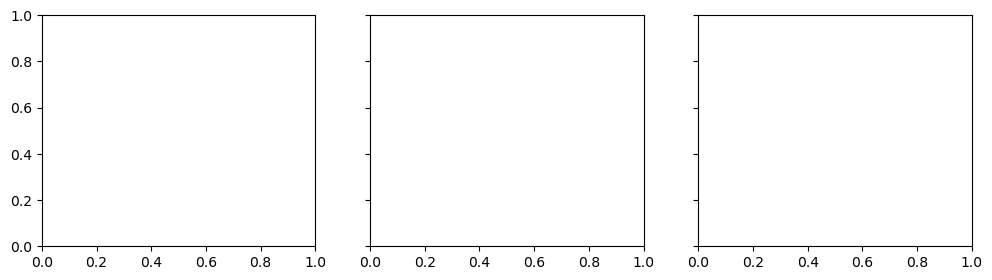

In [67]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3), sharex=True, sharey=True)
reach_pop_ss = reach_pop[reach_pop.country == 'NLD']
reach_pop_ss

Rotterdam [The Hague]
driving
cycling
walking
Amsterdam
driving
cycling
walking
Utrecht
driving
cycling
walking
Eindhoven
driving
cycling
walking
Nijmegen
driving
cycling
walking


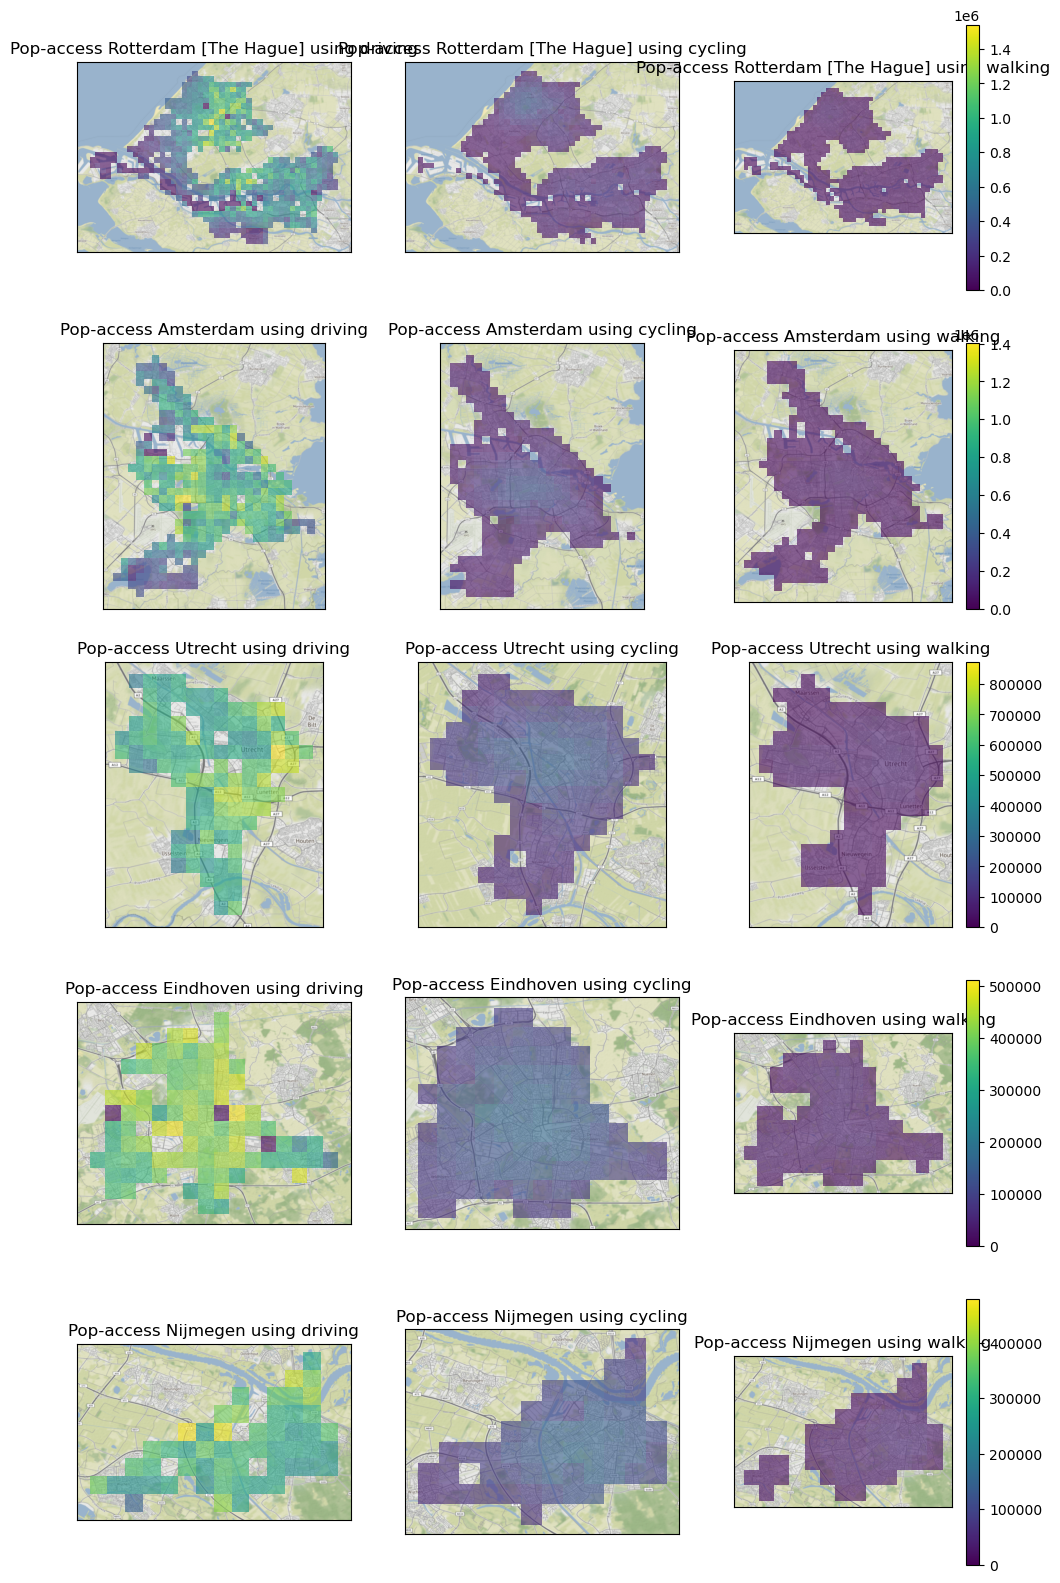

In [68]:
cities_names = reach_pop_ss.city_name.unique()
fig, axs = plt.subplots(ncols=3, nrows=len(cities_names), figsize=(12, 4*len(cities_names)))
modes = ['driving', 'cycling', 'walking']
for y, city_name in enumerate(cities_names):
    print(city_name)
    for x, mode in enumerate(modes):
        print(mode)
        reach_pop_ssi = reach_pop[reach_pop.city_name == city_name]
        reach_pop_ssi = reach_pop_ssi[reach_pop_ssi[mode] > reach_pop_ssi[mode].quantile(0.1)]
        
        ax = axs[y, x]
        reach_pop_ssi.plot(column=mode, legend=(x==2), alpha=0.6, ax=ax, vmin=0, vmax=reach_pop_ssi[modes].max().max())
        # reach_pop.apply(lambda x: ax.annotate(text=x['pid'], xy=x.raster.centroid.coords[0], ha='center', fontsize=6), axis=1)
        ax.set_title(f'Pop-access {city_name} using {mode}')
        ax.set_xticks([])
        ax.set_yticks([])
        ctx.add_basemap(ax=ax, crs=reach_pop_ssi.crs, attribution='')

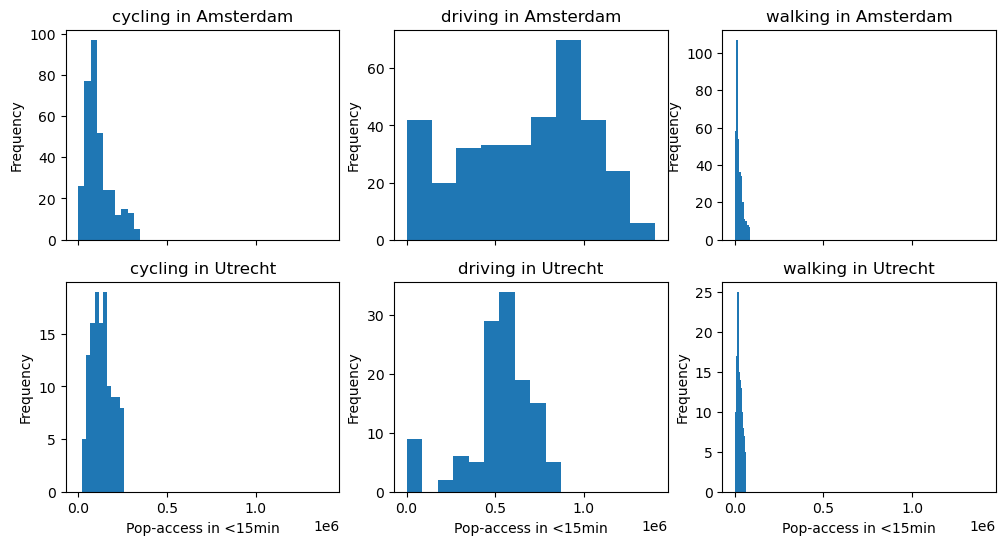

In [49]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 6), sharex=True)

for y, city_name in enumerate('Amsterdam', 'Utrecht'):
    for i, mode in enumerate(['cycling', 'driving', 'walking']):
        reach_pop[reach_pop.city_name == city_name][mode].plot.hist(ax=axs[y, i])
        axs[y, i].set_title(f"{mode} in {city_name}")
        axs[y, i].set_xlabel("Pop-access in <15min")

In [85]:
reach_pop['cycling_driving'] = reach_pop['cycling'] / reach_pop['driving']
reach_pop = reach_pop.sort_values('cycling_driving')
reach_pop

,city_id,pid,cycling,driving,walking,city_name,country,raster,cycling_driving
9323,2749,156,0.000000,104876.581932,0.000000,Copenhagen,DNK,"POLYGON ((884000.000 6457000.000, 884000.000 6...",0.000000
11295,3027,308,0.000000,854209.772252,33754.764709,Vienna,AUT,"POLYGON ((1277000.000 5679000.000, 1277000.000...",0.000000
9107,2682,129,0.000000,37237.114339,0.000000,Gothenburg,SWE,"POLYGON ((799000.000 6653000.000, 799000.000 6...",0.000000
10766,2973,222,0.000000,619810.031755,0.000000,Stockholm,SWE,"POLYGON ((1179000.000 6811000.000, 1179000.000...",0.000000
9109,2682,130,0.000000,173089.620256,0.000000,Gothenburg,SWE,"POLYGON ((800000.000 6653000.000, 800000.000 6...",0.000000
...,...,...,...,...,...,...,...,...,...
6345,2123,128,162938.150414,110.056282,20189.802849,Rotterdam [The Hague],NLD,"POLYGON ((325000.000 6085000.000, 325000.000 6...",1480.498409
5795,2051,153,55316.994521,27.955690,8634.541185,Barcelona,ESP,"POLYGON ((173000.000 4958000.000, 173000.000 4...",1978.738273
2078,1800,598,91791.625330,42.050777,13981.392360,Birmingham,GBR,"POLYGON ((-148000.000 6125000.000, -148000.000...",2182.875821
1602,1800,169,113799.348080,36.137035,5987.757755,Birmingham,GBR,"POLYGON ((-142000.000 6140000.000, -142000.000...",3149.105811


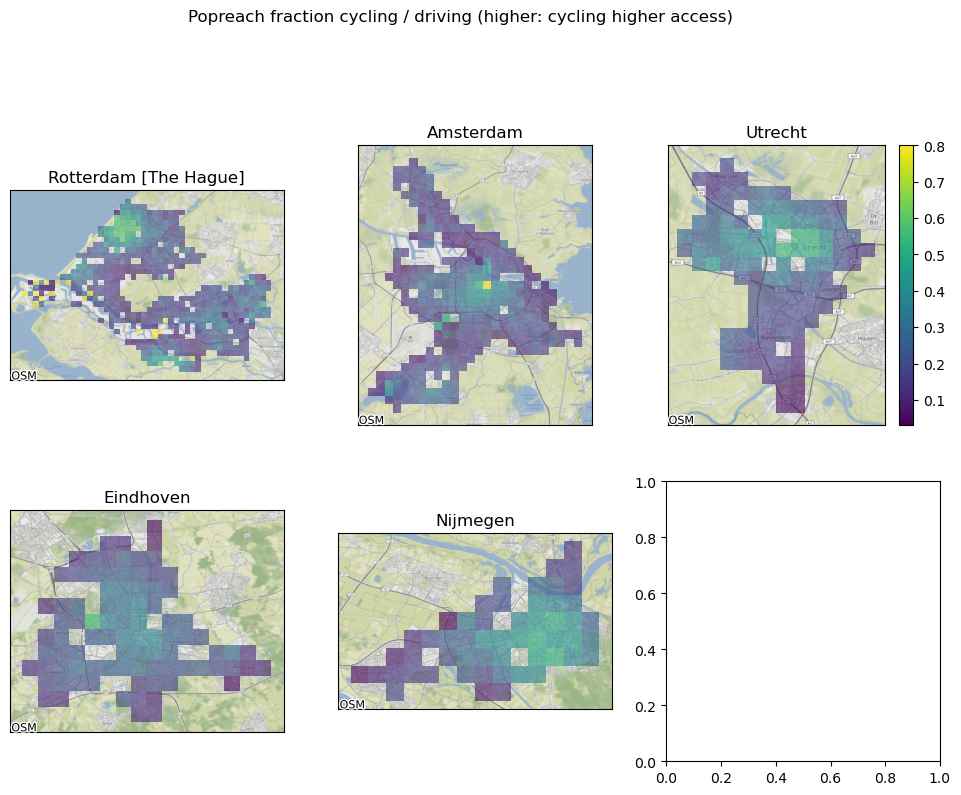

In [72]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))

for y, city_name in enumerate(reach_pop_ss.city_name.unique()):
    ax=axs[y//3, y%3]
    reach_pop[(reach_pop.cycling_driving < 2) & (reach_pop.city_name==city_name)].plot(
        column='cycling_driving', legend=y==2, alpha=0.6, ax=ax, vmax=0.8)
    # reach_pop.apply(lambda x: ax.annotate(text=x['pid'], xy=x.raster.centroid.coords[0], ha='center', fontsize=6), axis=1)
    ctx.add_basemap(ax=ax, crs=reach_pop.crs, attribution="OSM")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(city_name)
    fig.suptitle('Popreach fraction cycling / driving (higher: cycling higher access)', y=1.05, fontsize=12)

<Axes: xlabel='city_name'>

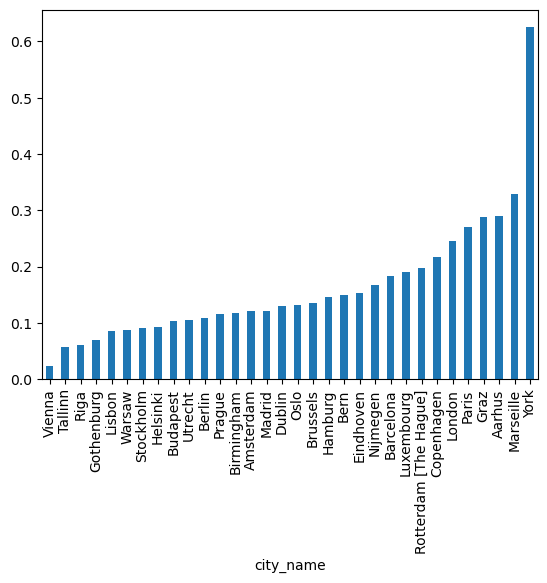

In [88]:
reach_pop.groupby('city_name').apply(lambda x: (x.cycling_driving > 0.5).sum() / len(x.cycling_driving)).sort_values().plot.bar()

In [ ]:
# Analysis of reach during off-peak and on-peak times
offpeak = isochrones[(isochrones.modetime == 'transit') & (isochrones.tt_mnts==15)
                    ].to_crs(isochrones.estimate_utm_crs()).area

onpeak  = isochrones[(isochrones.modetime == 'transit-peak') & (isochrones.tt_mnts==15)
                    ].to_crs(isochrones.estimate_utm_crs()).area
bins = np.linspace(0, 8e6, 17)
plt.hist([offpeak, onpeak], bins, label=['off', 'on'], )

In [ ]:
w = isochrones
w['area'] = isochrones.to_crs(isochrones.estimate_utm_crs()).area
wew = w.groupby('pid').area.sum()

ax = w[w.pid.isin(list(wew[wew < 100].index))].set_geometry('startpt').plot()
ctx.add_basemap(ax, crs=w.crs)

In [ ]:
fig, axs = plt.subplots(ncols=5, figsize=(20, 4))
for i, t in enumerate(range(5, 55, 10)):
    stockholm = client.get_isochrone(STADSHUSET, f'stockholm-{t}', t, STARTDATE, 'driving')
    stockholm.plot(ax=axs[i])
    ctx.add_basemap(axs[i], crs="EPSG:4326")